In [463]:
#   Imports
import numpy as np
import matplotlib.pyplot as plt
import random as rand
import torch
import torch.nn as nn

In [464]:
#   Constants

#   Peak positons for E,A at 532. from 1-4, bulk layers 
omega_0_MoS2_L = np.array([[384.7,402.7],[382.5,404.9],[382.4,405.7],[382.4,406.7],[383,407.8]])

In [465]:
#   Methods and functions
def gauss(omega, fwhm, omega_0):
    return np.exp(-0.5*(((omega-omega_0)/fwhm)**2))/(fwhm*((2*np.pi)**0.5))

def raman_moment(spectra, intesnity, order):
    output = 0
    for i in range(698):
        output += (spectra[i]**order) * intesnity[i]
    return output

def varaince(first_moment, second_moment):
    return np.sqrt(np.abs(((first_moment)**2)-second_moment))

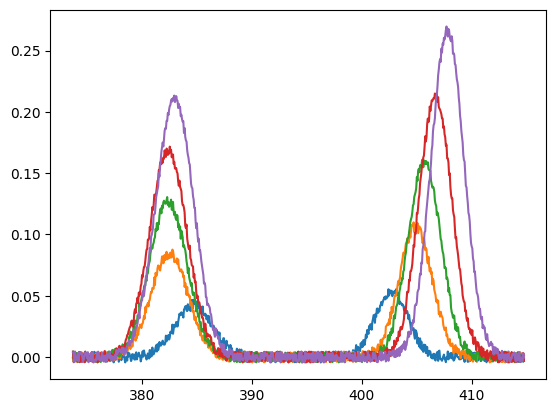

In [466]:
#   Testing sandbox
x = np.linspace(373.75,414.75,700)
y = np.zeros([5, 700])

for i in range(5):
    for j in range(700):
        y[i][j] = ((i+1)/5)*(0.9*gauss(x[j],1.7,omega_0_MoS2_L[i][0]) + gauss(x[j],1.5,omega_0_MoS2_L[i][1]))+(rand.randrange(-45,45)/10000)

for k in range(5):
    plt.plot(x,y[k])

In [467]:
#   Create 10000 samples with various layers and random noise as well as labels (layers)

samples = np.zeros([10000, 700])
layers = np.zeros(10000)
print(np.shape(samples))
for i in range(5):
    for j in range(2000*(i), 2000*(i+1)):
        layers[j] = i+1
        E_0 = omega_0_MoS2_L[i][0]
        A_0 = omega_0_MoS2_L[i][1]
        for k in range(700):
            samples[j][k] = ((i+1)/5)*(0.9*(gauss(x[k],1.7+(rand.randrange(-10,10)/75),omega_0_MoS2_L[i][0]+(rand.randrange(-10,10)/75)) + gauss(x[k],1.5+(rand.randrange(-10,10)/100),omega_0_MoS2_L[i][1]+(rand.randrange(-10,10)/100))))+(rand.randrange(-45,45)/10000)


(10000, 700)


In [472]:
#   Random sampling for test, train split

train_id = rand.sample(np.linspace(0,10000,10000).astype(np.int64).tolist(),7000)
print(train_id)

train_spectra = np.zeros([7000,700])
train_label = np.zeros([7000])
test_spectra = np.zeros([3000,700])
test_label = np.zeros([3000])

train_index = 0
test_index = 0
for i in range(10000):
    print(i)
    if i in train_id:
        train_spectra[train_index] = samples[i]
        train_label[train_index] = layers[i]
        train_index += 1
    else:
        test_spectra[test_index] = samples[i]
        test_label[test_index] = layers[i]
        test_index += 1

[4614, 4849, 6119, 5154, 1664, 4406, 5973, 2339, 6132, 8993, 9130, 1246, 2500, 4314, 895, 6679, 1375, 1300, 4825, 7711, 3533, 2486, 6865, 3660, 1237, 7804, 820, 2020, 7147, 3740, 409, 6456, 482, 559, 7085, 2383, 7521, 4722, 7867, 9163, 9022, 6077, 2061, 7842, 6530, 8297, 4112, 2857, 7193, 8747, 984, 5787, 8717, 3795, 6377, 6434, 7880, 1160, 478, 4498, 3157, 394, 3171, 3926, 5242, 7853, 9470, 7121, 5654, 9516, 9639, 6532, 2871, 6384, 5149, 7984, 8091, 2411, 9340, 1207, 2829, 3797, 8883, 8409, 5536, 8602, 816, 2484, 5421, 9922, 6639, 7951, 8511, 2696, 6366, 4003, 818, 7939, 3741, 7817, 3429, 9623, 4492, 8343, 8496, 7949, 3147, 361, 4563, 4620, 3758, 30, 6692, 5203, 4311, 940, 1067, 1402, 8057, 6828, 9086, 2523, 7869, 3279, 2666, 3752, 1750, 396, 452, 4334, 2429, 5589, 7443, 313, 8508, 7293, 4998, 647, 1090, 3210, 4471, 4845, 2715, 9985, 1221, 8688, 6110, 1552, 3352, 9748, 491, 5197, 5537, 5915, 5184, 5231, 8608, 122, 460, 8739, 6628, 2258, 4193, 8284, 522, 3102, 2314, 688, 3063, 3959, 25

In [473]:
#   Raman fingerprinting
fingerprint = np.zeros([10000,2])

for i in range(10000):
    first_moment = raman_moment(x,samples[i],1)
    second_moment = raman_moment(x,samples[i],2)
    # print(first_moment)
    # print(second_moment)
    fingerprint[i][0] = second_moment/1e5
    fingerprint[i][1] = varaince(first_moment,second_moment)/1e3

In [474]:
#   Define simple model
n_features = 1

class ConvNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(out_channels=64, in_channels=n_features, kernel_size = 3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(200))
        self.layer2 = nn.Flatten()
        self.layer3 = nn.Sequential(
            nn.Linear(192,100),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(100,6),
            nn.Softmax())
        
    def forward(self, x):
        out = x
        out = out.unsqueeze(1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out
    
#   Test data labels
trt_labels = np.zeros(7000)
tet_labels = np.zeros(3000)
for i in range(7000):
    trt_labels[i] = train_label[i] % 2
for i in range(3000):
    tet_labels[i] = test_label[i] % 2

In [475]:
#   Load model

model = ConvNet1D()
cirterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

total_step = len(train_spectra)

#   Intermediate step: convert to torch tensor
train_spectraT = (torch.from_numpy(train_spectra)).float()
test_spectraT = (torch.from_numpy(test_spectra)).float()
train_labelsT = torch.from_numpy(trt_labels).float()
test_labelsT = torch.from_numpy(tet_labels).float()
num_epochs = 5
batch_size = 64

#   print(np.shape(train_spectraT))

lost_list = []
acc_list = []

acc_list_epoch = []

In [ ]:
print(np.shape(train_spectraT))

torch.Size([7000, 700])


In [476]:
#   Training time, baby! Pray for me.

for epoch in range(num_epochs):
    correct_sum = 0
    for i in range(int(np.floor(total_step/batch_size))):
        train_spectraT_seg = train_spectraT[i*batch_size:(i+1)*batch_size]
        train_labelsT_seg = train_labelsT[i*batch_size:(i+1)*batch_size]

        # print(np.shape(train_spectraT_seg))
        # train_spectraT_seg = train_spectraT_seg.permute(1,0)
        #   Run the forward pass
        outputs = model(train_spectraT_seg)
        # print("outputs")
        # print(np.shape(outputs))
        # print(outputs)
        # print(np.shape(train_labelsT_seg.long()))
        # print(train_labelsT_seg.long())
        loss = cirterion(outputs, train_labelsT_seg.long())
        lost_list.append(loss.item())

        #   Backpropagation and Adam
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        #   Track accuracy
        # print("AAAAA: ", train_labelsT_seg.size(0))
        total = train_labelsT_seg.size(0)
        _, predicted = torch.max(outputs, 1)
        # _, actual = torch.max(train_labelsT_seg.long(), 0)
        # print("predicted, actual: ",predicted,", ",train_labelsT_seg.long())
        correct = (predicted == train_labelsT_seg.long()).sum().item()
        correct_sum = correct_sum + (correct/total)
        acc_list.append(correct / total)
    print("Epochs: ",epoch)
    print("Accuracy: ",correct_sum/int(np.floor(total_step/batch_size)))
    acc_list_epoch.append(correct_sum/int(np.floor(total_step/batch_size)))



C:\Users\Filip Gorajek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epochs:  0
Accuracy:  0.5819954128440367
Epochs:  1
Accuracy:  0.6003440366972477
Epochs:  2
Accuracy:  0.6003440366972477
Epochs:  3
Accuracy:  0.6003440366972477
Epochs:  4
Accuracy:  0.6003440366972477


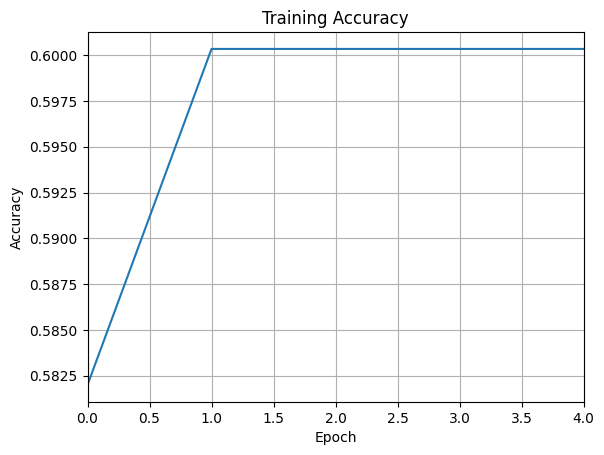

In [477]:
#   Plot the training accuracy
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(acc_list_epoch)
plt.show()
# print(correct_sum)

In [478]:
#   Test the model
model.eval()
with torch.no_grad():
    test_outputs = model(test_spectraT)
    _, predictedt = torch.max(test_outputs,1)
    total_t = test_labelsT.size(0)
    correct_t = (predictedt == test_labelsT.long()).sum().item()
    print("Test accuracy: ",(correct_t/total_t)*100)

Test accuracy:  59.599999999999994
